# Report of main experiment results

## Download the folder that contains the trained models in format .pth

In [1]:
!gdown 'https://drive.google.com/uc?id=1bIV1nqsRzD9aCISSxtyJX21go7FIw5z5&export=download'

Downloading...
From: https://drive.google.com/uc?id=1bIV1nqsRzD9aCISSxtyJX21go7FIw5z5&export=download
To: /content/Models.zip
100% 370M/370M [00:08<00:00, 45.3MB/s]


In [2]:
!unzip /content/Models.zip

Archive:  /content/Models.zip
   creating: Models/
   creating: Models/PTHs/
   creating: Models/PTHs/MelSpectogram/
  inflating: Models/PTHs/MelSpectogram/M1_MEL_16kHz.pth  
  inflating: Models/PTHs/MelSpectogram/M3_MEL_8kHz.pth  
  inflating: Models/PTHs/MelSpectogram/M1_MEL_8kHz.pth  
  inflating: Models/PTHs/MelSpectogram/M3_MEL_16kHz.pth  
  inflating: Models/PTHs/MelSpectogram/M2_MEL_16kHz.pth  
  inflating: Models/PTHs/MelSpectogram/M2_MEL_8kHz.pth  
   creating: Models/PTHs/CNN/
  inflating: Models/PTHs/CNN/C1_CNN_16kHz.pth  
  inflating: Models/PTHs/CNN/C1_CNN_8kHz.pth  
  inflating: Models/PTHs/CNN/C2_CNN_16kHz.pth  
  inflating: Models/PTHs/CNN/C2_CNN_8khz.pth  
   creating: Models/PTHs/LSTM/
  inflating: Models/PTHs/LSTM/L5_LSTM_16kHz.pth  
  inflating: Models/PTHs/LSTM/L3_LSTM_8kHz.pth  
  inflating: Models/PTHs/LSTM/L3_LSTM_16kHz.pth  
  inflating: Models/PTHs/LSTM/L1_LSTM_16kHz.pth  
  inflating: Models/PTHs/LSTM/L1_LSTM_8kHz.pth  
  inflating: Models/PTHs/LSTM/L2_LSTM_1

In [3]:
!pip install pydub
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt  
from textwrap import wrap
import numpy as np
import seaborn as sn

import librosa
import librosa.display
from base64 import b64decode
from IPython.display import Audio, Javascript
from pydub import AudioSegment
from scipy.io import wavfile

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load all the models from pth

### CNNs

In [5]:
#CNN_1
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

CNN_1_8kHz = torch.load('/content/Models/PTHs/CNN/C1_CNN_8kHz.pth').to(device)
CNN_1_16kHz = torch.load('/content/Models/PTHs/CNN/C1_CNN_16kHz.pth').to(device)

In [6]:
#CNN_2
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=128):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(8 * n_channel)
        self.conv6 = nn.Conv1d(8 * n_channel, 16 * n_channel, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(16 * n_channel)
        self.fc1 = nn.Linear(16 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

CNN_2_8kHz = torch.load('/content/Models/PTHs/CNN/C2_CNN_8khz.pth').to(device)
CNN_2_16kHz = torch.load('/content/Models/PTHs/CNN/C2_CNN_16kHz.pth').to(device)

### GRUs

In [7]:
#GRU-1
class GRU_1(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=2, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        x = self.fc1(hnn[-1])
        return F.log_softmax(x, dim=-1)

GRU_1_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-1_8kHz.pth').to(device)
GRU_1_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-1_16kHz.pth').to(device)

In [8]:
#GRU-2 
class GRU_2(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=4, num_layer=4):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        x = self.fc1(hnn[-1])
        return F.log_softmax(x, dim=-1)

GRU_2_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-2_8kHz.pth').to(device)
GRU_2_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-2_16kHz.pth').to(device)

In [9]:
#GRU_3
class GRU_3(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=4, num_layer=4):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        return self.fc1(hnn[-1])

GRU_3_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-3_8kHz.pth').to(device)
GRU_3_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-3-3layers_16kHz.pth').to(device)

In [10]:
#GRU_4
class GRU_4(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=256, n_channel=128, nhead=2, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        x = self.fc1(hnn[-1])
        return F.log_softmax(x, dim=-1)

GRU_4_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-4_8kHz.pth').to(device)
GRU_4_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-4_16kHz.pth').to(device)

In [11]:
#GRU_5
class GRU_5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=4, num_layer=4):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        x = self.fc1(hnn[-1])
        return F.log_softmax(x, dim=-1)

GRU_5_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-5_8kHz.pth').to(device)
GRU_5_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-5_16kHz.pth').to(device)

In [12]:
#GRU_6
class GRU_6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=4, num_layer=4):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2 * n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        return self.fc1(hnn[-1])

GRU_6_8kHz = torch.load('/content/Models/PTHs/GRU/GRU-6_8kHz.pth').to(device)
GRU_6_16kHz = torch.load('/content/Models/PTHs/GRU/GRU-6_16kHz.pth').to(device)

### LSTMs

In [13]:
#LSTM_1 
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

LSTM_1_8kHz = torch.load('/content/Models/PTHs/LSTM/L1_LSTM_8kHz.pth').to(device)
LSTM_1_16kHz = torch.load('/content/Models/PTHs/LSTM/L1_LSTM_16kHz.pth').to(device)

In [14]:
#LSTM_2
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=256, n_channel=128, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

LSTM_2_8kHz = torch.load('/content/Models/PTHs/LSTM/L2_LSTM_8kHz.pth').to(device)
LSTM_2_16kHz = torch.load('/content/Models/PTHs/LSTM/L2_LSTM_16kHz.pth').to(device)

In [15]:
#LSTM_3
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=2, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        #self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(2 * n_channel)
        #self.pool4 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        #x = self.conv4(x)
        #x = F.relu(self.bn4(x))
        #x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

LSTM_3_8kHz = torch.load('/content/Models/PTHs/LSTM/L3_LSTM_8kHz.pth').to(device)
LSTM_3_16kHz = torch.load('/content/Models/PTHs/LSTM/L3_LSTM_16kHz.pth').to(device)

In [16]:
#LSTM_4
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=2, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(2 * n_channel, 8 * n_channel, kernel_size=3)
        self.bn5 = nn.BatchNorm1d(8 * n_channel)
        self.pool5 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(8 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

LSTM_4_8kHz = torch.load('/content/Models/PTHs/LSTM/L4_LSTM_8kHz.pth').to(device)
LSTM_4_16kHz = torch.load('/content/Models/PTHs/LSTM/L4_LSTM_16kHz.pth').to(device)

In [17]:
#LSTM_5
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=256, n_channel=128, nhead=2, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(2 * n_channel, 8 * n_channel, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(8 * n_channel)
        self.pool5 = nn.MaxPool1d(4)
        self.conv6 = nn.Conv1d(8 * n_channel, 16 * n_channel, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(16 * n_channel)
        self.pool6 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(16 * n_channel, 8 * hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(8 * hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        x = self.conv6(x)
        x = F.relu(self.bn6(x))

        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

LSTM_5_8kHz = torch.load('/content/Models/PTHs/LSTM/L5_LSTM_8kHz.pth').to(device)
LSTM_5_16kHz = torch.load('/content/Models/PTHs/LSTM/L5_LSTM_16kHz.pth').to(device)

Group the models in lists by sample rate audio input.

In [18]:
models_8kHz = []
models_8kHz.append(CNN_1_8kHz)
models_8kHz.append(CNN_2_8kHz)
models_8kHz.append(GRU_1_8kHz)
models_8kHz.append(GRU_2_8kHz)
models_8kHz.append(GRU_3_8kHz)
models_8kHz.append(GRU_4_8kHz)
models_8kHz.append(GRU_5_8kHz)
models_8kHz.append(GRU_6_8kHz)
models_8kHz.append(LSTM_1_8kHz)
models_8kHz.append(LSTM_2_8kHz)
models_8kHz.append(LSTM_3_8kHz)
models_8kHz.append(LSTM_4_8kHz)
models_8kHz.append(LSTM_5_8kHz)


models_16kHz = []
models_16kHz.append(CNN_1_16kHz)
models_16kHz.append(CNN_2_16kHz)
models_16kHz.append(GRU_1_16kHz)
models_16kHz.append(GRU_2_16kHz)
models_16kHz.append(GRU_3_16kHz)
models_16kHz.append(GRU_4_16kHz)
models_16kHz.append(GRU_5_16kHz)
models_16kHz.append(GRU_6_16kHz)
models_16kHz.append(LSTM_1_16kHz)
models_16kHz.append(LSTM_2_16kHz)
models_16kHz.append(LSTM_3_16kHz)
models_16kHz.append(LSTM_4_16kHz)
models_16kHz.append(LSTM_5_16kHz)

## Create test set of dataset to test the models to obtain the results

In [19]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [20]:
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = test_set[0]
labels = sorted(list(set(datapoint[2] for datapoint in test_set)))

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [21]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [22]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [23]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [24]:
batch_size = 100
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [25]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

@torch.no_grad()
def evaluate(test_model, sample_rate, loss_f, data_source):
    test_model.eval()
    total_loss = 0.
    correct = 0
    n = 0

    y_true = []
    y_pred = []
    for data, target in data_source:

        data = data.to(device)
        target = target.to(device)

        if(sample_rate == 8000):
          # apply transform and model on whole batch directly on device
          data = transform(data)

        output = test_model(data)

        if loss_f == 'CEL':
          output = F.log_softmax(output, dim=-1)
  
          
        loss = F.nll_loss(output.squeeze(), target).item()

        total_loss += target.numel() * loss
        n += target.numel()

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        for i in range(target.numel()):
          true_label = index_to_label(target.data[i].item())
          pred_label = index_to_label(pred.data[i].item())
          y_true.append(true_label)
          y_pred.append(pred_label)

        losses.append(loss)
    
  
    accuracy = 100 * correct / len(test_loader.dataset)
    
    return total_loss / n, accuracy, y_true, y_pred

In [26]:
def varNames(var):
  d = globals()
  return [k for k in d if d[k] is var]

In [27]:
print('MODELS WITH 16kHz AUDIO INPUT')
print('-' *30)
print(' ')
for model in models_16kHz:
  losses = []
  sample_rate = 16000

  model_name = varNames(model)[0]

  if 'GRU_3' in model_name or 'GRU_6' in model_name:
    loss_f = 'CEL'
  else:
    loss_f = 'NLL'
    
  with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(model, sample_rate, loss_f, test_loader)

    print('-' * 90)
    print(f'| Model {model_name} | End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}% |')
    print('-' * 90)

print(' ')  
print('MODELS WITH 8kHz AUDIO INPUT')
print('-' *30)
print(' ')

for model in models_8kHz:
  losses = []
  transform = transform.to(device)
  sample_rate = 8000

  model_name = varNames(model)[0]

  if 'GRU_3' in model_name or 'GRU_6' in model_name:
    loss_f = 'CEL'
  else:
    loss_f = 'NLL'

  with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(model, sample_rate, loss_f, test_loader)

    print('-' * 90)
    print(f'| Model {model_name} | End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}% |')
    print('-' * 90)

MODELS WITH 16kHz AUDIO INPUT
------------------------------
 
------------------------------------------------------------------------------------------
| Model CNN_1_16kHz | End of training | test loss  0.62 | test accuracy 83% |
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
| Model CNN_2_16kHz | End of training | test loss  0.48 | test accuracy 85% |
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
| Model GRU_1_16kHz | End of training | test loss  0.28 | test accuracy 92% |
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
| Model GRU_2_16kHz | End of training | test loss  0.31 | test acc

# Confusion matrix
The confusion matrix of the models with best accuracy results.

Functions to create the confusion matrix and plot it.

In [28]:
def build_idx2keyword(keywordlist):
    idx2keyword = {}
    for i, keyword in enumerate(keywordlist):
      idx2keyword[i] = keyword
    return idx2keyword

In [29]:
def print_CM(y_true, y_pred, title):
  idx2keyword = build_idx2keyword(labels)
  cm = confusion_matrix(y_true, y_pred, labels=list(idx2keyword.values()), normalize=None)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=idx2keyword.values())
  fig = plt.figure(dpi=75, figsize=(15,10))
  ax = fig.add_subplot(111)
  title = ax.set_title("\n".join(wrap('MODEL: '+ title, 80)))
  title.set_y(1)
  disp.plot(ax=ax)
  l = list(idx2keyword.values())
  plt.xticks(np.arange(len(l)), l, rotation=90)
  plt.show()

## CNN
CNN 2 16kHz with 85% accuracy.

CNN 2 16kHz (85% accuracy)


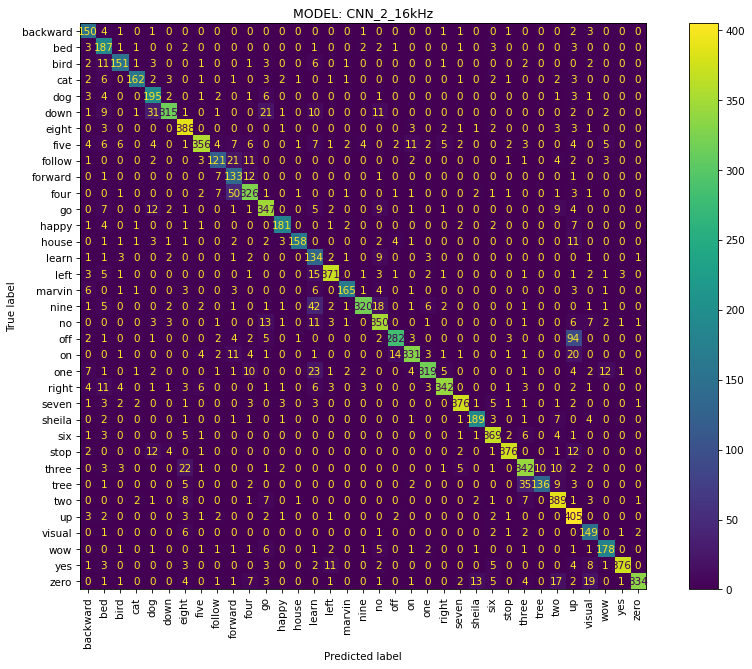

In [30]:
print('CNN 2 16kHz (85% accuracy)')
sample_rate = 16000
with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(CNN_2_16kHz, sample_rate, 'NLL', test_loader)
model_name = varNames(CNN_2_16kHz)[0]
print_CM(y_true, y_pred, model_name)

## GRU
GRU 3 8kHz and GRU 1 16kHz, both with 92% accuracy.

GRU 3 8kHz (92% accuracy)


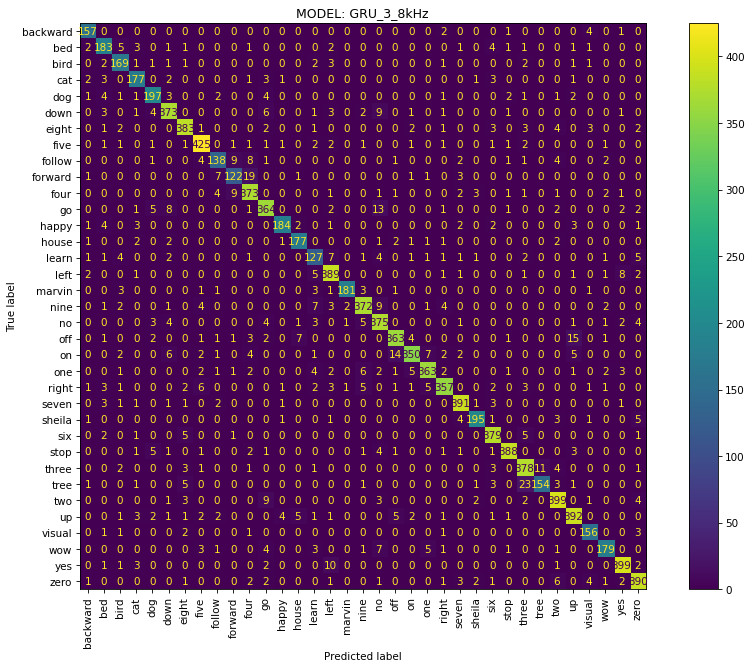

In [31]:
print('GRU 3 8kHz (92% accuracy)')
sample_rate = 8000
with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(GRU_3_8kHz, sample_rate, 'NLL', test_loader)
model_name = varNames(GRU_3_8kHz)[0]
print_CM(y_true, y_pred, model_name)

GRU 1 16kHz (92% accuracy)


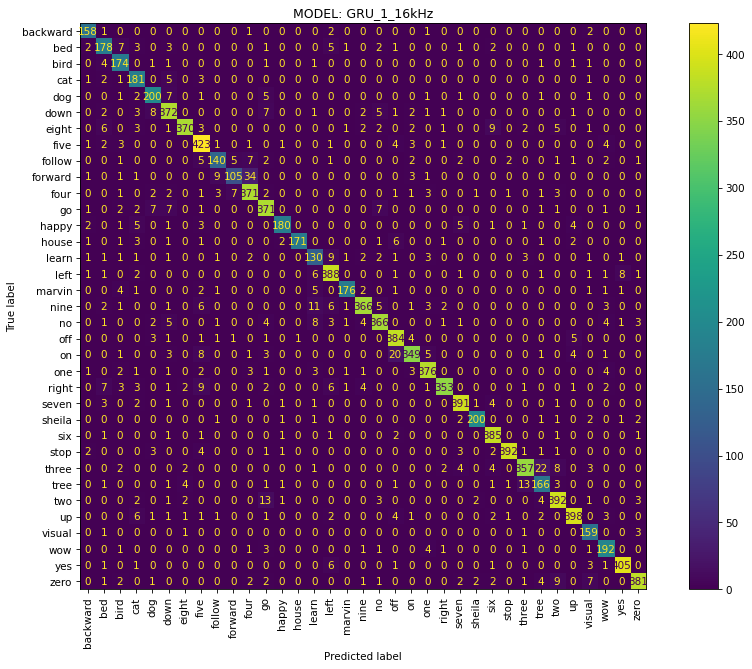

In [32]:
print('GRU 1 16kHz (92% accuracy)')
sample_rate = 16000
with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(GRU_1_16kHz, sample_rate, 'NLL', test_loader)
model_name = varNames(GRU_1_16kHz)[0]
print_CM(y_true, y_pred, model_name)

## LSTM
LSTM 2 16kHz with 92% accuracy.

LSTM 2 16kHz (92% accuracy)


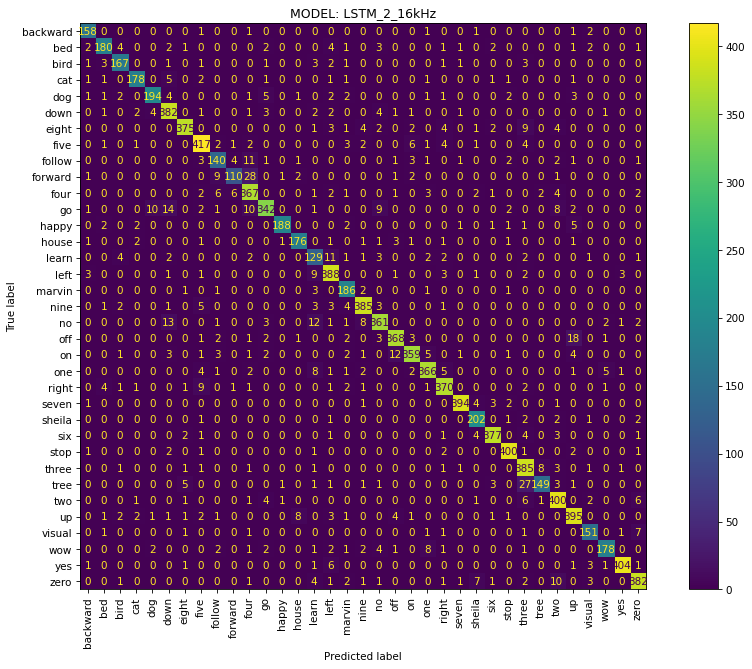

In [33]:
print('LSTM 2 16kHz (92% accuracy)')
sample_rate = 16000
with torch.no_grad():
    test_loss, test_acc, y_true, y_pred = evaluate(LSTM_2_16kHz, sample_rate, 'NLL', test_loader)
model_name = varNames(LSTM_2_16kHz)[0]
print_CM(y_true, y_pred, model_name)